In [18]:
"""
We use the limit cycle to predict the motion of the slider given velocity of the pusher.
This is implementing a recent paper by Alberto

Object models to be considered:
1) cylinders
2) blocks
"""
import numpy as np
class Geometry:
    def __init__(self, shape, mins, maxs, resols):
        self.shape = shape
        self.grid_size = (maxs-mins)/resols
        self.grid_size = np.ceil(self.grid_size).astype(int)
        self.mins = mins
        self.maxs = maxs
        self.resols = resols
        self.grid = np.zeros(self.grid_size).astype(int)  # an occupancy grid
        self.grid_x, self.grid_y = np.indices(self.grid_size)
        self.grid_x = self.resols[0] * (self.grid_x+0.5) + self.mins[0]
        self.grid_y = self.resols[1] * (self.grid_y+0.5) + self.mins[1]

    def update_grid(self):
        # obtain the occupancy grid based on the shape
        pass
    def local_inside(self, pt):
        pass

class CylinderShape(Geometry):
    def __init__(self, shape, mins, maxs, resols):
        super().__init__(shape, mins, maxs, resols)
        self.update_grid()
    def update_grid(self):
        # check the points if they're inside the grid
        inside = np.sqrt(self.grid_x ** 2 + self.grid_y ** 2)
        inside = inside <= self.shape
        self.grid = inside
    def local_inside(self, pt):
        return np.sqrt(pt[0]**2 + pt[1]**2) <= self.shape
class BlockShape(Geometry):
    def __init__(self, shape, mins, maxs, resols):
        super().__init__(shape, mins, maxs, resols)
        self.update_grid()
    def update_grid(self):
        # check the points if they're inside the grid
        inside = (self.grid_x <= self.shape[0]/2) & (self.grid_y <= self.shape[1]/2) & \
                (self.grid_x >= -self.shape[0]/2) & (self.grid_y >= -self.shape[1]/2)
        self.grid = inside
    def local_inside(self, pt):
        inside = (pt[0] <= self.shape[0]/2) & (pt[1] <= self.shape[1]/2) & \
                (pt[0] >= -self.shape[0]/2) & (pt[1] >= -self.shape[1]/2)
        return inside
        

from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt
import matplotlib.tri as mtri

class Slider:
    def __init__(self, transform, shape):
        # transform: x,y,theta
        # shape: cylinder is radius, block is (height, width)
        self.transform = transform
        x,y,theta = transform
        tf_mat = [[np.cos(theta), -np.sin(theta),x], [np.sin(theta), np.cos(theta),y],[0,0,1]]
        tf_mat = np.array(tf_mat)
        self.tf_mat = tf_mat
        self.shape = shape
        self.tran_vel = np.zeros((2))
        self.rot_vel = 0
        self.type = 'none'
        self.hull = None
    def global_inside(self, pt):
        tf_mat = np.linalg.inv(self.tf_mat)
        pt = tf_mat[:2,:2].dot(pt) + tf_mat[:2,2]
        return self.geo.local_inside(pt)
    def get_tf_mat(self, transform):
        x,y,theta = transform
        tf_mat = [[np.cos(theta), -np.sin(theta),x], [np.sin(theta), np.cos(theta),y],[0,0,1]]
        tf_mat = np.array(tf_mat)
        return tf_mat
    def update_transform(self, new_transform):
        self.transform = new_transform
        self.tf_mat = self.get_tf_mat(new_transform)
    def update_vel(self, tran_vel, rot_vel):
        self.tran_vel = tran_vel
        self.rot_vel = rot_vel
    def get_contact_pt(self, contact_angle):
        pass
    def get_contact_angle_from_global(self, contact_pt):
        # first project contact pt to the local frame
        tf_mat_local = np.linalg.inv(self.tf_mat)
        contact_pt = tf_mat_local[:2,:2].dot(contact_pt) + tf_mat_local[:2,2]
        return self.get_contact_angle_from_local(contact_pt)
    def get_contact_angle_from_local(self, contact_pt):
        return np.arctan2(contact_pt[1], contact_pt[0])
        
    def get_normal_local(self, contact_angle):
        # any convex object can map 1-to-1 to a unit circle
        # this is in the local frame
        pass
    def get_contact_pts(self, contact_angles):
        # input: N
        # output: Nx2
        pass
    def get_normals_local(self, contact_angles):
        # input: N
        # output: Nx2
        pass
    
    def get_tran_vel(self, contact_angle, vel):
        # get the vector from contact point to COM
        pt = self.get_contact_pt(contact_angle)
        pt = pt/np.linalg.norm(pt)
        return vel.dot(pt)*pt
    def get_rot_vel(self, contact_angle, vel):
        # get the vector from contact point to COM
        pt = self.get_contact_pt(contact_angle)
        norm = np.linalg.norm(pt)
        pt = pt/np.linalg.norm(pt)
        # linear_v = vel - vel.dot(norm)*norm
        linear_v = np.cross(vel, pt)  # |a||b|sin(theta)
        ang_v = linear_v / norm
        return ang_v
    def get_vel_in_local(self, vel):
        """
        given a velocity in the global frame, get the relative velocity in the local frame
        """
        tf_mat = self.tf_mat
        tf_mat = np.linalg.inv(tf_mat)
        return tf_mat[:2,:2].dot(vel)
    
    def get_vel_at_contact(self, contact_angle, tran_vel, rot_vel):
        # get the contact poitn velocity, assuming the object is undergoing velocity
        pass
    def get_cur_vel_at_contact(self, contact_angle):
        # get the contact point velocity based on the object current velocity
        pass
    """
    for getting the limit surface
    """
    def get_total_friction_at_pt(self, f, r):
        # TODO: consider coefficient and mass
        torque = np.cross(r, f)
        load = np.array([f[0], f[1], torque[2]])
        return load
    def get_total_friction_from_v(self, v):
        """
        v: [vx, vy, omega]
        """
        # get the local velocity of each point
        vx = np.zeros(self.geo.grid.shape) + v[0]
        vy = np.zeros(self.geo.grid.shape) + v[1]
        vx = vx - v[2] * self.geo.grid_y
        vy = vy + v[2] * self.geo.grid_x
        v_size = np.sqrt(vx ** 2 + vy ** 2)
        fx = vx / v_size
        fy = vy / v_size
        fw = self.geo.grid_x * fy - self.geo.grid_y * fx
        F = np.array([fx[self.geo.grid].sum(), fy[self.geo.grid].sum(), 
                      fw[self.geo.grid].sum()]) * self.geo.resols[0] * self.geo.resols[1]
        return F
    def construct_ls_db(self, n_samples=2500, ax=None):
        """
        sample velocities, and compute the (F,M) values. Then store them into a db
        Then we can:
        1. use convex hull of the sampled (F,M) to construct the limit surface
        2. use nearest neighbor to find velocity
        """
        points = np.random.normal(size=(n_samples,3))
        print(points.shape)
        points = points / np.linalg.norm(points, axis=1).reshape((-1,1))
        fs = []
        for i in range(len(points)):
            f = self.get_total_friction_from_v(points[i])
            fs.append(f)
        fs = np.array(fs)

        hull = ConvexHull(fs)

        # triple
        x = fs[:,0]
        y = fs[:,1]
        z = fs[:,2]

        # Triangulate parameter space to determine the triangles
        tri = mtri.Triangulation(x,y,triangles=hull.simplices)

        # Plot the surface.  The triangles in parameter space determine which x, y, z
        # points are connected by an edge.
        if ax is not None:
            ax.plot_trisurf(x, y, z, triangles=tri.triangles, cmap=plt.cm.Spectral)
        
#         if ax is not None:
#             ax.plot_trisurf(fs[:,0], fs[:,1], fs[:,2], linewidth=0.2, antialiased=True)
        
#         # Plot defining corner points
#         if ax is not None:
#             ax.plot(fs[:,0], fs[:,1], fs[:,2], "ko")

#         # 12 = 2 * 6 faces are the simplices (2 simplices per square face)
#         for s in hull.simplices:
#             s = np.append(s, s[0])  # Here we cycle back to the first coordinate
#             if ax is not None:
#                 ax.plot(fs[s, 0], fs[s, 1], fs[s, 2], "r-")            
        self.hull = hull
        return hull
    def get_ls_vel(self, f, plot_scale=0.1, ax=None):
        # https://stackoverflow.com/questions/30486312/intersection-of-nd-line-with-convex-hull-in-python
        if self.hull is None:
            self.construct_ls_db(ax=ax)
        # find the face that the force projects to
        eq=self.hull.equations.T
        V,b=eq[:-1].T,eq[-1]
        alpha=-b/np.dot(V,f)
        alpha[alpha<=0] = np.inf
        face_idx = np.argmin(alpha)
        proj_pt = alpha[face_idx]*f
        # TODO: plot this
        normal = self.hull.equations[face_idx,:-1]        
        normal = normal / np.linalg.norm(normal) * plot_scale
        if ax is not None:
            plt.plot([proj_pt[0],proj_pt[0]+normal[0]],
                     [proj_pt[1],proj_pt[1]+normal[1]],
                     [proj_pt[2],proj_pt[2]+normal[2]])

        return normal
    def get_ls_f(self, vel, ax=None):
        # find the force that corresponds to the normal direction vel
        # the one with the max inner product
        if self.hull is None:
            self.construct_ls_db(ax=ax)

        vel = vel / np.linalg.norm(vel)
        idx = np.argmax(self.hull.points.dot(vel))
        return self.hull.points[idx]
    
    
# TODO: implement cylinder and block sliders. Write an animation for these
class CylinderSlider(Slider):
    def __init__(self, transform, shape):
        super().__init__(transform, shape)
        self.radius = shape  # shape is a float
        self.type = 'cylinder'
        mins = np.array([-self.radius, -self.radius])
        maxs = np.array([self.radius, self.radius])
        resols = np.array([0.01, 0.01])
        self.geo = CylinderShape(shape, mins, maxs, resols)

    def get_contact_pt(self, contact_angle):
        return self.radius*np.array([np.cos(contact_angle),np.sin(contact_angle)])
    def get_contact_pt_in_world(self, contact_angle):
        contact_pt = self.get_contact_pt(contact_angle)
        return self.tf_mat[:2,:2].dot(contact_pt) + self.tf_mat[:2,2]

    def get_normal_local(self, contact_angle):
        return -np.array([np.cos(contact_angle),np.sin(contact_angle)])

    def get_contact_pts(self, contact_angles):
        return self.radius*np.array([np.cos(contact_angles),np.sin(contact_angles)]).T
    def get_normals_local(self, contact_angles):
        return -np.array([np.cos(contact_angles),np.sin(contact_angles)]).T
        
    
    def get_vel_at_contact(self, contact_angle, tran_vel, rot_vel):
        linear_v = rot_vel * self.radius
        linear_v = np.array([0,0,linear_v])
        # get the vector pointing from the COM to the contact point. This is useful to get the
        # linear velocity at the contact point
        contact_pt = self.get_contact_pt(contact_angle)
        contact_pt_vec = self.tf_mat[:2,:2].dot(contact_pt)
        contact_pt_vec = contact_pt_vec / np.linalg.norm(contact_pt_vec)
        contact_pt_vec = np.array([contact_pt_vec[0], contact_pt_vec[1], 0])
        linear_v = np.cross(linear_v,contact_pt_vec)[:2]
        return tran_vel + linear_v
    def get_cur_vel_at_contact(self, contact_angle):
        # get the contact point velocity based on the object current velocity
        return self.get_vel_at_contact(contact_angle, self.tran_vel, self.rot_vel)
    
    
class BlockSlider(Slider):
    def __init__(self, transform, shape):
        super().__init__(transform, shape)
        self.width = shape[0]
        self.height = shape[1]
        shape = np.array(shape)
        self.shape = np.array(shape[:2])
        self.type = 'block'
        mins = -shape/2
        maxs = shape/2
        resols = np.array([0.01, 0.01])
        self.geo = BlockShape(shape, mins, maxs, resols)
        
    def get_contact_pt(self, contact_angle):
        pt = np.array([np.cos(contact_angle),np.sin(contact_angle)])
        # map to rectangular
        ratio = np.array([self.width,self.height])/2/np.abs(pt)
        ratio = np.min(ratio)
        pt = pt * ratio
        return pt
    def get_contact_pt_in_world(self, contact_angle):
        contact_pt = self.get_contact_pt(contact_angle)
        return self.tf_mat[:2,:2].dot(contact_pt) + self.tf_mat[:2,2]
    def get_normal_local(self, contact_angle):
        # this is useful to project the velocity to ignore friction
        pt = self.get_contact_pt(contact_angle)
        if (pt[0] > -self.width/2) and (pt[0] < self.width/2):
            norm = -np.array([0,np.sign(pt[1])])
        if (pt[1] > -self.height/2) and (pt[1] < self.height/2):
            norm = -np.array([np.sign(pt[0]),0])
        return norm

    def get_contact_pts(self, contact_angles):
        pt = np.array([np.cos(contact_angles),np.sin(contact_angles)])
        # map to rectangular
        ratio = np.array([self.width,self.height]).reshape((2,1))/2/np.abs(pt)
        ratio = np.min(ratio, axis=0).reshape((1,-1))
        pt = pt * ratio
        return pt.T
    
    def get_normals_local(self, contact_angles):
        # this is useful to project the velocity to ignore friction
        pt = self.get_contact_pts(contact_angles)
        norm = np.zeros((len(pt),2))
        mask = (pt[:,0] > -self.width/2) & (pt[:,0] < self.width/2)
        mask_pt = -np.sign(pt[mask])
        mask_pt[:,0] = 0
        norm[mask] = mask_pt
        mask = (pt[:,1] > -self.height/2) & (pt[:,1] < self.height/2)
        mask_pt = -np.sign(pt[mask])
        mask_pt[:,1] = 0
        norm[mask] = mask_pt
        return norm            
    
    def get_vel_at_contact(self, contact_angle, tran_vel, rot_vel):
        pt = self.get_contact_pt(contact_angle)
        linear_v = rot_vel * np.linalg.norm(pt)
        linear_v = np.array([0,0,linear_v])
        # get the vector pointing from the COM to the contact point. This is useful to get the
        # linear velocity at the contact point
        contact_pt = self.get_contact_pt(contact_angle)
        contact_pt_vec = self.tf_mat[:2,:2].dot(contact_pt)
        contact_pt_vec = contact_pt_vec / np.linalg.norm(contact_pt_vec)
        contact_pt_vec = np.array([contact_pt_vec[0], contact_pt_vec[1], 0])
        linear_v = np.cross(linear_v,contact_pt_vec)[:2]
        return tran_vel + linear_v
    def get_cur_vel_at_contact(self, contact_angle):
        # get the contact point velocity based on the object current velocity
        return self.get_vel_at_contact(contact_angle, self.tran_vel, self.rot_vel)

# TODO: what about robot models? How to infer that?
# maybe we can randomly select a point on the robot arm geometry, and assuming convex shape. Then
# iteratively refine until the robot geometry roughly covers the point and is normal to that.
# This pushing motion will be noisy, so we need a controller to decide the velocity after a certain
# period for feedback control

class System:
    def __init__(self, slider: Slider, dt):
        self.slider = slider
        self.dt = dt
    def get_contact_point(self, pusher_pt):
        """
        at current slider transform, get the current contact point given the pusher point in the world frame
        """
        pass
    def update_slider_transform(self, s0, v0, v1):
        """
        v0: velocity before updating the velocity of the slider. (e.g. default is static)
        v1: velocity after update
        both v0 and v1 are of form [vx, vy, omega]
        """
        # we use a simple euler integration
        s1 = s0 + self.dt * v1
        self.slider.update_transform(s1)
        return s1
    
    def get_vel_in_local(self, vel):
        """
        given a velocity in the global frame, get the relative velocity in the local frame
        """
        tf_mat = self.slider.tf_mat
        tf_mat = np.linalg.inv(tf_mat)
        return tf_mat[:2,:2].dot(vel)

    def update_slider_rel(self, contact_angle, pusher_rel_vel):
        """
        given the contact angle, update the slider velocity and transform.
        The pusher_rel_velocity is in the frame of the slider
        NOTE: in quasi-static assumption, we basically assume that the contact velocity is equivalent
        to the pusher velocity in the slider after the pusher-slider friction effect
        NOTE: the pusher and slider may lose contact if we don't project one to the other. We need
        to update the slider by projecting it at the contact to the pusher afterward.
        """
        # frictionless: we ignore the tangent velocity to the boundary, and only take the normal velocity
        print('input pusher_rel_vel: ', pusher_rel_vel)
#         norm = self.slider.get_normal_local(contact_angle)
#         projection = pusher_rel_vel.dot(norm)
#         projection = max(projection, 0)  # ignore when the object is departing
#         pusher_rel_vel = projection * norm

        # if the pusher velociy is not pointing inside the object, then ignore
        
    
        pusher_vel = self.slider.tf_mat[:2,:2].dot(pusher_rel_vel)
        pt = self.slider.get_contact_pt(contact_angle)
        # get pt in the global
        pt_global = self.slider.tf_mat[:2,:2].dot(pt) + self.slider.tf_mat[:2,2]
        
        # quasi-static: don't count previous velocities anymore
        friction = np.array(pusher_rel_vel)
        friction = np.array([friction[0], friction[1], 0])
        friction = friction / np.linalg.norm(friction)
        f = self.slider.get_total_friction_at_pt(friction, pt)
        vel_dir = self.slider.get_ls_vel(f)  # this is normalized velocity. Only a direction
        # match the velocity of the pusher: the contact point needs to have similiar velocity size
        vel_contact = self.slider.get_vel_at_contact(contact_angle, vel_dir[:2], vel_dir[2])
        vel_scale = np.linalg.norm(pusher_rel_vel) / np.linalg.norm(vel_contact)
        vel_slider = vel_dir * vel_scale
        vel_dx = pusher_rel_vel - vel_contact * vel_scale
        
        
        self.slider.tran_vel = [0,0]
        self.slider.rot_vel = 0
        tran_vel = self.slider.tran_vel + self.slider.tf_mat[:2,:2].dot(vel_slider[:2])
        rot_vel = self.slider.rot_vel + vel_slider[2]
        
        tran_vel += self.slider.tf_mat[:2,:2].dot(vel_dx)
        v0 = np.array([self.slider.tran_vel[0],self.slider.tran_vel[1],self.slider.rot_vel])
        v1 = np.array([tran_vel[0],tran_vel[1],rot_vel])
        
        print('slider velocity: ', vel_slider)
        print('pusher velocity: ', pusher_rel_vel)
        print('contact velocity: ', vel_contact)

        
        
        transform = self.update_slider_transform(self.slider.transform, v0, v1)

        new_pt = self.slider.get_contact_pt_in_world(contact_angle)
        pt_dx = new_pt - pt_global
#         print('slider vs pusher: ', pt_dx - pusher_vel * dt)
#         print('pusher travel: ', pusher_vel * dt)

        # project the contact point to the pusher new waypoint
#         new_pt = self.slider.get_contact_pt_in_world(contact_angle)
#         # get the translation of the contact point
        dx = pusher_vel * self.dt - (new_pt - pt_global)
        tran_vel += dx  # project the slider so that the pusher is at the boundary
        transform[:2] += dx
#         # TODO: add cone control afterward



        self.slider.update_transform(transform)
        self.slider.update_vel(tran_vel, rot_vel)

    def update_slider(self, contact_angle, pusher_vel_in_slider):
        """
        given the contact angle, update the slider velocity and transform.
        The pusher_vel_in_slider is in the frame of the slider
        NOTE: in quasi-static assumption, we basically assume that 
        the object becomes static and follows pusher velocity again
        """
        self.update_slider_rel(contact_angle, pusher_vel_in_slider)
        
    


In [19]:
"""
NOTE: different from the base in:
1) we will get the mapping from (v,w) -> (F,I) -> r
2) to do this, we solve the optimization problem to find
    argmin |r1f2-r2f1-I|  for (r1,r2) in O
    where O stands for the object boundary
    we can do this optimization by sampling (r1,r2) in O, and then find the min one (or by threshold)
    It may be that min |r1f2-r2f1-I| > 0. In this case, there is no solution to the optimization problem
    
TODO: also need to make sure the F is valid, i.e. in the motion cone at the boundary pt
"""

import matplotlib.pyplot as plt
import matplotlib.tri as mtri
import matplotlib as mpl
def load_to_position(slider: Slider, load, ax=None):
    """
    load: [f1,f2,I]
    """
    # * step 1: sample points in the object geometry
    contact_angles = np.linspace(start=0, stop=np.pi*2, num=100, endpoint=False)
    contact_pts = slider.get_contact_pts(contact_angles)  # N x 2
    # draw the contact pts
    # get the normal vector to filter objects that are not "pushing"
    contact_normals = slider.get_normals_local(contact_angles)
    valid_mask = contact_normals.dot(load[:2]) >= 0

    # * step 2: find the one that minimizes |r1f2-r2f1-I|
    value = contact_pts[:,0]*load[1] - contact_pts[:,1]*load[0] - load[2]
    value = value / np.linalg.norm(load)  # normalize w.r.t. load vector
    value = np.abs(value)
    small = 5*np.pi/180  # this is the wrench error we allow. Could have multiple solutions
    print('value: ')
    print(value)
    mask = valid_mask & (value < small)
    
    # plot the value contact pt and the force direction
    if slider.type == 'cylinder':
        slider_anim = plt.Circle((0,0),
                            slider.radius, color='b')
    else:
        slider_anim = plt.Rectangle(np.zeros((2))-slider.shape/2,
                                         slider.width,
                                         slider.height,
                                         color='b')
        transform = slider.transform
    ax.add_patch(slider_anim)

    
    force_indices = np.where(mask)[0]
    print('force_indices: ')
    print(force_indices)
    for i in range(0,len(force_indices),5):
        idx = force_indices[i]
        scale = 1.0
        force = np.array([load[0], load[1]])*scale
        print('contact_pts: ')
        print(contact_pts.shape)
        print('force: ')
        print(force)
        print('idx: ', idx)
        arrow = plt.arrow(contact_pts[idx,0],contact_pts[idx,1], force[0],force[1], width=0.02,color='r')
        ax.add_patch(arrow)
#         break
    
    # * step 3: check if the force at the contact is pointing inside the object
    plt.scatter(contact_pts[:,0], contact_pts[:,1], color='yellow', zorder=3)


(2500, 3)
value: 
[0.06296255 0.05802204 0.05304227 0.0479827  0.04280021 0.03744754
 0.03187146 0.02601048 0.01979189 0.01312771 0.00590925 0.00200075
 0.01077934 0.01933754 0.02625906 0.03249573 0.03818716 0.04344157
 0.04834464 0.05296576 0.05736224 0.06158258 0.06566874 0.06965798
 0.07358431 0.07747967 0.08137504 0.08530137 0.08929061 0.09337677
 0.0975971  0.10199359 0.1066147  0.11151778 0.11677218 0.12246362
 0.12870029 0.13562181 0.13460951 0.12583092 0.11792093 0.11070246
 0.10403828 0.09781969 0.09195872 0.08638264 0.08102997 0.07584748
 0.07078791 0.06580813 0.06086762 0.05592711 0.05094734 0.04588777
 0.04070528 0.03535261 0.02977653 0.02391556 0.01769697 0.01103279
 0.00381432 0.00409567 0.01287427 0.02143246 0.02835399 0.03459066
 0.04028209 0.04553649 0.05043957 0.05506068 0.05945717 0.06367751
 0.06776366 0.0717529  0.07567923 0.0795746  0.08346997 0.08739629
 0.09138553 0.09547169 0.09969203 0.10408852 0.10870963 0.11361271
 0.11886711 0.12455854 0.13079521 0.13771674

<ipython-input-18-7b6b7479d5a4>:316: RuntimeWarning: divide by zero encountered in divide
  ratio = np.array([self.width,self.height]).reshape((2,1))/2/np.abs(pt)


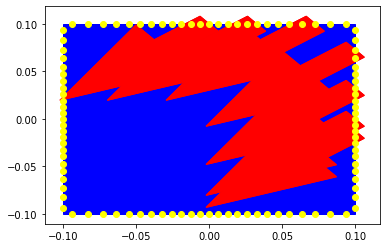

In [20]:
slider = BlockSlider([0,0,0], [0.2,0.2])
vel = np.random.normal(size=(3))
vel = vel / np.linalg.norm(vel)
load = slider.get_ls_f(vel)

ax = plt.subplot(111)
load_to_position(slider, load, ax)

In [27]:
"""
loop from velocity to pushing force animation to achieve a target pose
loop:
- get pose difference. Obtain velocity vector. Obtain load required
- obtain the pushing point and force. Apply the force for a set duration.
- loop
"""

def vel_to_contact(slider: Slider, vel, ax=None):
    """
    load: [f1,f2,I]
    """
    load = slider.get_ls_f(vel)

    # * step 1: sample points in the object geometry
    contact_angles = np.linspace(start=0, stop=np.pi*2, num=100, endpoint=False)
    contact_pts = slider.get_contact_pts(contact_angles)  # N x 2
    # draw the contact pts
    # get the normal vector to filter objects that are not "pushing"
    contact_normals = slider.get_normals_local(contact_angles)
    valid_mask = contact_normals.dot(load[:2]) >= 0

    # * step 2: find the one that minimizes |r1f2-r2f1-I|
    value = contact_pts[:,0]*load[1] - contact_pts[:,1]*load[0] - load[2]
    value = value / np.linalg.norm(load)  # normalize w.r.t. load vector
    value = np.abs(value)
    small = 5*np.pi/180  # this is the wrench error we allow. Could have multiple solutions
    mask = valid_mask & (value < small)
    
    mask_indices = np.linspace(0,len(mask)-1,len(mask)).astype(int)
    
    masked_value = value[mask]
    masked_indices = mask_indices[mask]
    idx = np.argmin(masked_value)
    idx = masked_indices[idx]
    
#     force_indices = np.where(mask)[0]
#     idx = force_indices[0]
    scale = .1
    force = np.array([load[0],load[1]])
    force = force / np.linalg.norm(force) * 0.1
    contact_pt = contact_pts[idx]
    contact_angle = contact_angles[idx]
    return contact_angle, contact_pt, force
    


In [28]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
import matplotlib as mpl
from IPython import display
"""
implement the animation for the pusher-slider system
"""
class SystemAnimationTargetPusher:
    def __init__(self, slider: Slider, target_pose, dt):
        self.system = System(slider, dt)
        self.target_pose = target_pose
        self.fig, self.ax = plt.subplots(figsize=(8, 8))
        self.dt = dt
        self.pusher_contact_angle = 0
        self.pusher_rel_vel = 0
    def get_ori(self):
        # get the orientation x0, x1, y0, y1 for the slider
        vec = self.system.slider.tf_mat[:2,:2].dot([1,0]) * 0.1
        start_pos = self.system.slider.transform[:2]
        end_pos = start_pos + vec
        return start_pos, end_pos

    def init_anim(self):
        # plot the slider at the start position
        if self.system.slider.type == 'cylinder':
            self.slider_anim = plt.Circle((self.system.slider.transform[0],self.system.slider.transform[1]),
                                self.system.slider.radius, color='b')
            start_ori, end_ori = self.get_ori()
            self.slider_ori_anim, = self.ax.plot([start_ori[0], end_ori[0]],
                                           [start_ori[1], end_ori[1]],
                                           color='r')
        else:
            self.slider_anim = plt.Rectangle(self.system.slider.transform[:2]-self.system.slider.shape/2,
                                             self.system.slider.width,
                                             self.system.slider.height,
                                             color='b')
            transform = self.system.slider.transform
            t = mpl.transforms.Affine2D().rotate_deg_around(transform[0], transform[1], \
                                                            transform[2]/np.pi * 180) + self.ax.transData
            self.slider_anim.set_transform(t)
            start_ori, end_ori = self.get_ori()
            self.slider_ori_anim, = self.ax.plot([start_ori[0], end_ori[0]],
                                           [start_ori[1], end_ori[1]],
                                           color='r')
            
        # plot the pusher
        # get the transform of the pusher in the world frame
        pusher_pt = self.system.slider.get_contact_pt_in_world(self.pusher_contact_angle)
        self.pusher_anim = plt.Circle((pusher_pt[0], pusher_pt[1]), 0.01, color='green')
        self.ax.set_xlim(-2, 2)
        self.ax.set_ylim(-2, 2)

        self.ax.add_patch(self.slider_anim)
        self.ax.add_patch(self.pusher_anim)
        return self.slider_anim, self.pusher_anim, self.slider_ori_anim, 
    def step(self, i):
        print('step: ', i)
        # given current transform and target, obtain the velocity
        current_pose = np.array(self.system.slider.transform)
        delta_pose = self.target_pose - current_pose
        delta_pose[2] = delta_pose[2] % (np.pi*2)
        if delta_pose[2] > np.pi:
            delta_pose[2] = delta_pose[2] - np.pi*2
        print('delta_pose: ', delta_pose)
        contact_angle, contact_pt, force = vel_to_contact(self.system.slider, delta_pose)
        self.pusher_contact_angle = contact_angle
        self.pusher_rel_vel = force
        
        # update the slider based on the pusher
        self.system.update_slider(self.pusher_contact_angle, self.pusher_rel_vel)
        if self.system.slider.type == 'cylinder':
            self.slider_anim.center = self.system.slider.transform[0],self.system.slider.transform[1]
        else:
            transform = self.system.slider.transform
            self.slider_anim.set_xy([transform[0]-self.system.slider.width/2, 
                                     transform[1]-self.system.slider.height/2])
            t = mpl.transforms.Affine2D().rotate_deg_around(transform[0], transform[1], \
                                                            transform[2]/np.pi * 180) + self.ax.transData
            self.slider_anim.set_transform(t)      
        start_ori, end_ori = self.get_ori()
#         print('start ori: ', start_ori)
#         print('start ori: ', start_ori)

        self.slider_ori_anim.set_xdata([start_ori[0], end_ori[0]])
        self.slider_ori_anim.set_ydata([start_ori[1], end_ori[1]])

        # get the relative position again
        pusher_pt = self.system.slider.get_contact_pt_in_world(self.pusher_contact_angle)
        self.pusher_anim.center = pusher_pt[0],pusher_pt[1]
        
        return self.slider_anim, self.pusher_anim,
    def anim(self):
        ani = FuncAnimation(self.fig, self.step, frames=np.arange(0,400,1),
                            init_func=self.init_anim, interval=int(1000*self.dt), blit=False)
        video = ani.to_html5_video()
        html = display.HTML(video)
        display.display(html)
        plt.close()


In [30]:
slider = BlockSlider([0,0,0], [0.2,0.2])
vel = np.random.normal(size=(3))
vel = vel / np.linalg.norm(vel)
load = slider.get_ls_f(vel)

target_pose = np.array([0.5,1.,np.pi/4])

anim = SystemAnimationTargetPusher(slider, target_pose, 0.05)
anim.anim()



(2500, 3)
step:  0
delta_pose:  [0.5        1.         0.78539816]
input pusher_rel_vel:  [0.04487286 0.08936681]
slider velocity:  [0.04439248 0.08844918 0.10915974]
pusher velocity:  [0.04487286 0.08936681]
contact velocity:  [0.03753735 0.05654345]


<ipython-input-18-7b6b7479d5a4>:297: RuntimeWarning: divide by zero encountered in divide
  ratio = np.array([self.width,self.height])/2/np.abs(pt)
<ipython-input-18-7b6b7479d5a4>:316: RuntimeWarning: divide by zero encountered in divide
  ratio = np.array([self.width,self.height]).reshape((2,1))/2/np.abs(pt)


step:  1
delta_pose:  [0.49830285 0.99527632 0.77994018]
input pusher_rel_vel:  [0.04487286 0.08936681]
slider velocity:  [0.0443636  0.08839162 0.1090887 ]
pusher velocity:  [0.04487286 0.08936681]
contact velocity:  [0.03755627 0.05658394]
step:  2
delta_pose:  [0.49663116 0.9905436  0.77448574]
input pusher_rel_vel:  [0.04487286 0.08936681]
slider velocity:  [0.04433479 0.08833422 0.10901786]
pusher velocity:  [0.04487286 0.08936681]
contact velocity:  [0.03757495 0.0566245 ]
step:  3
delta_pose:  [0.49498494 0.98580201 0.76903485]
input pusher_rel_vel:  [0.04487286 0.08936681]
slider velocity:  [0.04430606 0.08827698 0.10894722]
pusher velocity:  [0.04487286 0.08936681]
contact velocity:  [0.03759341 0.05666514]
step:  4
delta_pose:  [0.49336424 0.98105166 0.76358749]
input pusher_rel_vel:  [0.04487286 0.08936681]
slider velocity:  [0.04427741 0.08821991 0.10887678]
pusher velocity:  [0.04487286 0.08936681]
contact velocity:  [0.03761162 0.05670586]
step:  5
delta_pose:  [0.4917690

step:  35
delta_pose:  [0.44058203 0.83550472 0.69709506]
input pusher_rel_vel:  [0.04725058 0.08813276]
slider velocity:  [ 0.0475281   0.08833728 -0.06237838]
pusher velocity:  [0.04725058 0.08813276]
contact velocity:  [0.03471935 0.07720913]
step:  36
delta_pose:  [0.43829175 0.83105071 0.70021398]
input pusher_rel_vel:  [0.04725058 0.08813276]
slider velocity:  [ 0.04751755  0.08831767 -0.06236454]
pusher velocity:  [0.04725058 0.08813276]
contact velocity:  [0.03472694 0.07722632]
step:  37
delta_pose:  [0.43598766 0.82660382 0.70333221]
input pusher_rel_vel:  [0.04725058 0.08813276]
slider velocity:  [ 0.04750701  0.08829808 -0.0623507 ]
pusher velocity:  [0.04725058 0.08813276]
contact velocity:  [0.03473459 0.07724348]
step:  38
delta_pose:  [0.43366978 0.82216411 0.70644975]
input pusher_rel_vel:  [0.04725058 0.08813276]
slider velocity:  [ 0.04749648  0.08827849 -0.06233687]
pusher velocity:  [0.04725058 0.08813276]
contact velocity:  [0.03474229 0.07726062]
step:  39
delta_

step:  70
delta_pose:  [0.36262692 0.67898706 0.73414709]
input pusher_rel_vel:  [0.04857812 0.08740805]
slider velocity:  [0.048078   0.08751149 0.02107009]
pusher velocity:  [0.04857812 0.08740805]
contact velocity:  [0.0492335  0.08472776]
step:  71
delta_pose:  [0.3605333  0.67444558 0.73309359]
input pusher_rel_vel:  [0.04857812 0.08740805]
slider velocity:  [0.04807678 0.08750928 0.02106956]
pusher velocity:  [0.04857812 0.08740805]
contact velocity:  [0.04923458 0.08473   ]
step:  72
delta_pose:  [0.35844446 0.6699019  0.73204011]
input pusher_rel_vel:  [0.04857812 0.08740805]
slider velocity:  [0.04807557 0.08750707 0.02106903]
pusher velocity:  [0.04857812 0.08740805]
contact velocity:  [0.04923566 0.08473223]
step:  73
delta_pose:  [0.35636041 0.66535602 0.73098666]
input pusher_rel_vel:  [0.04857812 0.08740805]
slider velocity:  [0.04807436 0.08750486 0.0210685 ]
pusher velocity:  [0.04857812 0.08740805]
contact velocity:  [0.04923674 0.08473447]
step:  74
delta_pose:  [0.35

step:  104
delta_pose:  [0.29413992 0.52337209 0.69834284]
input pusher_rel_vel:  [0.04857812 0.08740805]
slider velocity:  [0.04803683 0.08743655 0.02105205]
pusher velocity:  [0.04857812 0.08740805]
contact velocity:  [0.04926893 0.08480432]
step:  105
delta_pose:  [0.29221012 0.51875862 0.69729023]
input pusher_rel_vel:  [0.04857812 0.08740805]
slider velocity:  [0.04803562 0.08743435 0.02105152]
pusher velocity:  [0.04857812 0.08740805]
contact velocity:  [0.04926993 0.08480659]
step:  106
delta_pose:  [0.29028517 0.51414312 0.69623766]
input pusher_rel_vel:  [0.05067322 0.08621035]
slider velocity:  [0.04909556 0.08477741 0.10457735]
pusher velocity:  [0.05067322 0.08621035]
contact velocity:  [0.04188762 0.05581575]
step:  107
delta_pose:  [0.28869242 0.50938579 0.69100879]
input pusher_rel_vel:  [0.05067322 0.08621035]
slider velocity:  [0.04906576 0.08472597 0.10451389]
pusher velocity:  [0.05067322 0.08621035]
contact velocity:  [0.04190502 0.05585567]
step:  108
delta_pose:  

step:  140
delta_pose:  [0.24643166 0.34951563 0.51933805]
input pusher_rel_vel:  [0.05675293 0.08233532]
slider velocity:  [0.05388009 0.07591911 0.14856029]
pusher velocity:  [0.05675293 0.08233532]
contact velocity:  [0.04032198 0.04034294]
step:  141
delta_pose:  [0.24561785 0.34454123 0.51191004]
input pusher_rel_vel:  [0.05675293 0.08233532]
slider velocity:  [0.053818   0.07583162 0.14838909]
pusher velocity:  [0.05675293 0.08233532]
contact velocity:  [0.04034371 0.04041425]
step:  142
delta_pose:  [0.24484005 0.33956121 0.50449058]
input pusher_rel_vel:  [0.05675293 0.08233532]
slider velocity:  [0.05375635 0.07574475 0.1482191 ]
pusher velocity:  [0.05675293 0.08233532]
contact velocity:  [0.04036488 0.04048564]
step:  143
delta_pose:  [0.24409824 0.33457582 0.49707963]
input pusher_rel_vel:  [0.05675293 0.08233532]
slider velocity:  [0.05369514 0.0756585  0.14805032]
pusher velocity:  [0.05675293 0.08233532]
contact velocity:  [0.04038549 0.0405571 ]
step:  144
delta_pose:  

step:  177
delta_pose:  [0.216774   0.16532527 0.25729053]
input pusher_rel_vel:  [0.08045299 0.05939122]
slider velocity:  [ 0.08225211  0.06096023 -0.04036962]
pusher velocity:  [0.08045299 0.05939122]
contact velocity:  [0.07058937 0.05721815]
step:  178
delta_pose:  [0.21456747 0.16083395 0.25930901]
input pusher_rel_vel:  [0.08045299 0.05939122]
slider velocity:  [ 0.08224474  0.06095477 -0.04036601]
pusher velocity:  [0.08045299 0.05939122]
contact velocity:  [0.07059307 0.05722652]
step:  179
delta_pose:  [0.21235189 0.15634708 0.26132731]
input pusher_rel_vel:  [0.08045299 0.05939122]
slider velocity:  [ 0.08223736  0.0609493  -0.04036239]
pusher velocity:  [0.08045299 0.05939122]
contact velocity:  [0.07059678 0.05723489]
step:  180
delta_pose:  [0.21012729 0.15186468 0.26334543]
input pusher_rel_vel:  [0.08045299 0.05939122]
slider velocity:  [ 0.08222998  0.06094383 -0.04035876]
pusher velocity:  [0.08045299 0.05939122]
contact velocity:  [0.0706005  0.05724324]
step:  181
d

step:  211
delta_pose:  [0.13894668 0.01477534 0.12527715]
input pusher_rel_vel:  [0.09940738 0.01087074]
slider velocity:  [0.0960094  0.01046884 0.05281153]
pusher velocity:  [0.09940738 0.01087074]
contact velocity:  [0.0906428  0.00609247]
step:  212
delta_pose:  [0.13554232 0.01111022 0.12263657]
input pusher_rel_vel:  [0.09957689 0.00918928]
slider velocity:  [0.09185202 0.0080608  0.11397659]
pusher velocity:  [0.09957689 0.00918928]
contact velocity:  [ 6.82114337e-02 -2.59118559e-05]
step:  213
delta_pose:  [0.13230877 0.00728079 0.11693774]
input pusher_rel_vel:  [0.09981028 0.00615693]
slider velocity:  [0.08622136 0.00328519 0.18498463]
pusher velocity:  [0.09981028 0.00615693]
contact velocity:  [ 0.04875619 -0.00479311]
step:  214
delta_pose:  [0.12925109 0.00329583 0.10768851]
input pusher_rel_vel:  [0.099967   0.00256892]
slider velocity:  [0.09378653 0.00320802 0.09099474]
pusher velocity:  [0.099967   0.00256892]
contact velocity:  [ 0.07645523 -0.00269413]
step:  215

step:  247
delta_pose:  [-0.01072396 -0.01558625  0.00351811]
input pusher_rel_vel:  [-0.05651941 -0.0824958 ]
slider velocity:  [-0.04937471 -0.07323351  0.12961461]
pusher velocity:  [-0.05651941 -0.0824958 ]
contact velocity:  [-0.04103868 -0.04879251]
step:  248
delta_pose:  [-0.01237418 -0.01083534 -0.00296262]
input pusher_rel_vel:  [-0.07509974 -0.06603052]
slider velocity:  [-0.0826968  -0.07105171 -0.10530051]
pusher velocity:  [-0.07509974 -0.06603052]
contact velocity:  [-0.04557937 -0.04769718]
step:  249
delta_pose:  [-0.01138802 -0.00590879  0.00230241]
input pusher_rel_vel:  [-0.08843764 -0.04667745]
slider velocity:  [-0.08263789 -0.04298647  0.08071986]
pusher velocity:  [-0.08843764 -0.04667745]
contact velocity:  [-0.07421629 -0.03277369]
step:  250
delta_pose:  [-0.01034282 -0.00100654 -0.00173358]
input pusher_rel_vel:  [-0.09955284 -0.00944623]
slider velocity:  [-0.10812852 -0.00773856 -0.1251295 ]
pusher velocity:  [-0.09955284 -0.00944623]
contact velocity:  [-

step:  283
delta_pose:  [-0.0015296  -0.00412597 -0.00619436]
input pusher_rel_vel:  [-0.03397732 -0.09405074]
slider velocity:  [-0.03805285 -0.10611056 -0.18632322]
pusher velocity:  [-0.03397732 -0.09405074]
contact velocity:  [-0.00905133 -0.04501909]
step:  284
delta_pose:  [-0.00276256  0.0007866   0.0031218 ]
input pusher_rel_vel:  [-0.09620142  0.02729994]
slider velocity:  [-0.09106831  0.02576464  0.07018358]
pusher velocity:  [-0.09620142  0.02729994]
contact velocity:  [-0.08040438  0.02716976]
step:  285
delta_pose:  [ 0.00142745  0.00352109 -0.00038738]
input pusher_rel_vel:  [0.03857144 0.09226182]
slider velocity:  [0.03738449 0.08664058 0.07024529]
pusher velocity:  [0.03857144 0.09226182]
contact velocity:  [0.03767252 0.07620335]
step:  286
delta_pose:  [ 0.00367385 -0.00095306 -0.00389965]
input pusher_rel_vel:  [ 0.09699348 -0.02433648]
slider velocity:  [ 0.09709021 -0.02459844 -0.00216225]
pusher velocity:  [ 0.09699348 -0.02433648]
contact velocity:  [ 0.0968004

step:  319
delta_pose:  [-0.0020234  -0.003898   -0.00660024]
input pusher_rel_vel:  [-0.04656761 -0.08849552]
slider velocity:  [-0.04757069 -0.0951146  -0.08450527]
pusher velocity:  [-0.04656761 -0.08849552]
contact velocity:  [-0.02821693 -0.06799702]
step:  320
delta_pose:  [-0.00307485  0.00100392 -0.00237498]
input pusher_rel_vel:  [-0.09484997  0.03167782]
slider velocity:  [-0.09205149  0.03070877  0.03888399]
pusher velocity:  [-0.09484997  0.03167782]
contact velocity:  [-0.08983823  0.0328558 ]
step:  321
delta_pose:  [ 0.00129985  0.00342984 -0.00431918]
input pusher_rel_vel:  [0.03644064 0.093124  ]
slider velocity:  [ 0.03785969  0.09397078 -0.01716829]
pusher velocity:  [0.03644064 0.093124  ]
contact velocity:  [0.03519849 0.09073041]
step:  322
delta_pose:  [ 0.00323909 -0.00117926 -0.00346076]
input pusher_rel_vel:  [ 0.09494082 -0.03140446]
slider velocity:  [ 0.10995779 -0.03231899 -0.24001033]
pusher velocity:  [ 0.09494082 -0.03140446]
contact velocity:  [ 0.0374

step:  355
delta_pose:  [-9.73821249e-04 -3.14644455e-03 -2.43231129e-05]
input pusher_rel_vel:  [-0.02881834 -0.09575752]
slider velocity:  [-0.02973965 -0.10102128 -0.07578469]
pusher velocity:  [-0.02881834 -0.09575752]
contact velocity:  [-0.0174498  -0.07507459]
step:  356
delta_pose:  [-0.00298525  0.00143814  0.00376491]
input pusher_rel_vel:  [-0.0897614   0.04407824]
slider velocity:  [-0.08592078  0.04355914  0.04504955]
pusher velocity:  [-0.0897614   0.04407824]
contact velocity:  [-0.08236373  0.04537115]
step:  357
delta_pose:  [0.00166904 0.0032699  0.00151243]
input pusher_rel_vel:  [0.04594838 0.08881861]
slider velocity:  [0.04339384 0.08179905 0.08800054]
pusher velocity:  [0.04594838 0.08881861]
contact velocity:  [0.04113699 0.06660235]
step:  358
delta_pose:  [ 0.00363494 -0.00133209 -0.00288759]
input pusher_rel_vel:  [ 0.09354977 -0.03533329]
slider velocity:  [ 0.1033033  -0.04125706 -0.15602611]
pusher velocity:  [ 0.09354977 -0.03533329]
contact velocity:  [ 

step:  391
delta_pose:  [-0.00074305 -0.00324398 -0.00033881]
input pusher_rel_vel:  [-0.02157543 -0.09764477]
slider velocity:  [-0.02117217 -0.08717012  0.13104805]
pusher velocity:  [-0.02157543 -0.09764477]
contact velocity:  [-0.02027825 -0.05961396]
step:  392
delta_pose:  [-0.00398428  0.00059325 -0.00689122]
input pusher_rel_vel:  [-0.09859057  0.01673017]
slider velocity:  [-0.11476057  0.02076793 -0.27908383]
pusher velocity:  [-0.09859057  0.01673017]
contact velocity:  [-0.03303539 -0.00129979]
step:  393
delta_pose:  [0.00080614 0.00227537 0.00706298]
input pusher_rel_vel:  [0.03521604 0.09359397]
slider velocity:  [0.02496591 0.07053924 0.29487823]
pusher velocity:  [0.03521604 0.09359397]
contact velocity:  [0.0168558  0.02821972]
step:  394
delta_pose:  [ 0.00414787 -0.00151795 -0.00768094]
input pusher_rel_vel:  [ 0.09451947 -0.03265072]
slider velocity:  [ 0.10305655 -0.03905476 -0.14317758]
pusher velocity:  [ 0.09451947 -0.03265072]
contact velocity:  [ 0.05359294 -

In [31]:
# slider = BlockSlider([0,0,0], [0.2,0.2])
slider = CylinderSlider([0,0,0], 0.2)

vel = np.random.normal(size=(3))
vel = vel / np.linalg.norm(vel)
load = slider.get_ls_f(vel)

target_pose = np.array([0.5,1.,np.pi/4])

anim = SystemAnimationTargetPusher(slider, target_pose, 0.05)
anim.anim()



(2500, 3)
step:  0
delta_pose:  [0.5        1.         0.78539816]
input pusher_rel_vel:  [0.04411718 0.08974226]
slider velocity:  [0.0441744  0.08941287 0.02843787]
pusher velocity:  [0.04411718 0.08974226]
contact velocity:  [0.04755857 0.08388324]
step:  1
delta_pose:  [0.49805154 0.99539199 0.78397627]
input pusher_rel_vel:  [0.04411718 0.08974226]
slider velocity:  [0.04417084 0.08940566 0.02843558]
pusher velocity:  [0.04411718 0.08974226]
contact velocity:  [0.04756189 0.0838903 ]
step:  2
delta_pose:  [0.49610961 0.99078122 0.78255449]
input pusher_rel_vel:  [0.04411718 0.08974226]
slider velocity:  [0.04416728 0.08939845 0.02843329]
pusher velocity:  [0.04411718 0.08974226]
contact velocity:  [0.04756519 0.08389736]
step:  3
delta_pose:  [0.49417422 0.9861677  0.78113283]
input pusher_rel_vel:  [0.04411718 0.08974226]
slider velocity:  [0.04416372 0.08939125 0.028431  ]
pusher velocity:  [0.04411718 0.08974226]
contact velocity:  [0.04756849 0.08390443]
step:  4
delta_pose:  

step:  35
delta_pose:  [0.44179735 0.83481658 0.69927199]
input pusher_rel_vel:  [0.0468464  0.08834826]
slider velocity:  [0.04426155 0.08504305 0.09412088]
pusher velocity:  [0.0468464  0.08834826]
contact velocity:  [0.04608865 0.0584462 ]
step:  36
delta_pose:  [0.44072741 0.82989012 0.69456594]
input pusher_rel_vel:  [0.04714873 0.08818728]
slider velocity:  [0.04377634 0.08417123 0.1078922 ]
pusher velocity:  [0.04714873 0.08818728]
contact velocity:  [0.04458322 0.05344954]
step:  37
delta_pose:  [0.43979453 0.8249189  0.68917133]
input pusher_rel_vel:  [0.04714873 0.08818728]
slider velocity:  [0.0437285  0.08407924 0.1077743 ]
pusher velocity:  [0.04714873 0.08818728]
contact velocity:  [0.04461072 0.05352576]
step:  38
delta_pose:  [0.43888736 0.81994311 0.68378262]
input pusher_rel_vel:  [0.04714873 0.08818728]
slider velocity:  [0.0436809  0.08398773 0.10765699]
pusher velocity:  [0.04714873 0.08818728]
contact velocity:  [0.04463778 0.05360203]
step:  39
delta_pose:  [0.43

step:  70
delta_pose:  [0.40584011 0.66270792 0.57209395]
input pusher_rel_vel:  [0.05021764 0.08647652]
slider velocity:  [0.05011374 0.08361743 0.0435347 ]
pusher velocity:  [0.05021764 0.08647652]
contact velocity:  [0.05475514 0.07599299]
step:  71
delta_pose:  [0.40471883 0.6578268  0.56991721]
input pusher_rel_vel:  [0.05021764 0.08647652]
slider velocity:  [0.05010478 0.08360247 0.04352691]
pusher velocity:  [0.05021764 0.08647652]
contact velocity:  [0.05476019 0.07601001]
step:  72
delta_pose:  [0.4036081  0.65294326 0.56774087]
input pusher_rel_vel:  [0.05021764 0.08647652]
slider velocity:  [0.05009582 0.08358754 0.04351913]
pusher velocity:  [0.05021764 0.08647652]
contact velocity:  [0.0547652  0.07602703]
step:  73
delta_pose:  [0.40250793 0.64805734 0.56556491]
input pusher_rel_vel:  [0.05021764 0.08647652]
slider velocity:  [0.05008688 0.08357262 0.04351136]
pusher velocity:  [0.05021764 0.08647652]
contact velocity:  [0.05477017 0.07604407]
step:  74
delta_pose:  [0.40

step:  108
delta_pose:  [0.35831837 0.47859721 0.48694308]
input pusher_rel_vel:  [0.05940528 0.08044261]
slider velocity:  [0.05878249 0.07958478 0.01673239]
pusher velocity:  [0.05940528 0.08044261]
contact velocity:  [0.06173564 0.07823102]
step:  109
delta_pose:  [0.35682042 0.47382537 0.48610646]
input pusher_rel_vel:  [0.05940528 0.08044261]
slider velocity:  [0.05878094 0.07958268 0.01673195]
pusher velocity:  [0.05940528 0.08044261]
contact velocity:  [0.06173655 0.07823366]
step:  110
delta_pose:  [0.35532646 0.46905228 0.48526986]
input pusher_rel_vel:  [0.05940528 0.08044261]
slider velocity:  [0.05877939 0.07958058 0.01673151]
pusher velocity:  [0.05940528 0.08044261]
contact velocity:  [0.06173745 0.0782363 ]
step:  111
delta_pose:  [0.3538365  0.46427795 0.48443328]
input pusher_rel_vel:  [0.05940528 0.08044261]
slider velocity:  [0.05877783 0.07957848 0.01673107]
pusher velocity:  [0.05940528 0.08044261]
contact velocity:  [0.06173835 0.07823894]
step:  112
delta_pose:  

step:  142
delta_pose:  [0.32118531 0.3122646  0.37015156]
input pusher_rel_vel:  [0.07158439 0.06982603]
slider velocity:  [0.0643736  0.06203531 0.10014953]
pusher velocity:  [0.07158439 0.06982603]
contact velocity:  [0.06202395 0.04125192]
step:  143
delta_pose:  [0.32026412 0.30729566 0.36514408]
input pusher_rel_vel:  [0.07158439 0.06982603]
slider velocity:  [0.06432214 0.06198572 0.10006946]
pusher velocity:  [0.07158439 0.06982603]
contact velocity:  [0.0620486  0.04132245]
step:  144
delta_pose:  [0.31936707 0.30232243 0.36014061]
input pusher_rel_vel:  [0.07328846 0.0680353 ]
slider velocity:  [0.06427097 0.06193641 0.09998986]
pusher velocity:  [0.07328846 0.0680353 ]
contact velocity:  [0.06207288 0.04139304]
step:  145
delta_pose:  [0.31837961 0.29739144 0.35514111]
input pusher_rel_vel:  [0.07328846 0.0680353 ]
slider velocity:  [0.0642201  0.06188738 0.09991071]
pusher velocity:  [0.07328846 0.0680353 ]
contact velocity:  [0.06209678 0.0414637 ]
step:  146
delta_pose:  

step:  178
delta_pose:  [0.27028503 0.13911022 0.22796854]
input pusher_rel_vel:  [0.08882095 0.04594386]
slider velocity:  [0.08470464 0.04375174 0.0402785 ]
pusher velocity:  [0.08882095 0.04594386]
contact velocity:  [0.08863366 0.0384692 ]
step:  179
delta_pose:  [0.2680831  0.13461491 0.22595462]
input pusher_rel_vel:  [0.08882095 0.04594386]
slider velocity:  [0.08469372 0.0437461  0.04027331]
pusher velocity:  [0.08882095 0.04594386]
contact velocity:  [0.08864131 0.03848288]
step:  180
delta_pose:  [0.26589017 0.1301152  0.22394095]
input pusher_rel_vel:  [0.09014394 0.04329052]
slider velocity:  [0.08025602 0.03790381 0.08763613]
pusher velocity:  [0.09014394 0.04329052]
contact velocity:  [0.07662979 0.02356927]
step:  181
delta_pose:  [0.26399454 0.12545965 0.21955915]
input pusher_rel_vel:  [0.09014394 0.04329052]
slider velocity:  [0.0802117  0.03788288 0.08758773]
pusher velocity:  [0.09014394 0.04329052]
contact velocity:  [0.07665956 0.02362317]
step:  182
delta_pose:  

step:  214
delta_pose:  [ 0.17081866 -0.00898302  0.12294662]
input pusher_rel_vel:  [ 0.09971685 -0.00751998]
slider velocity:  [ 0.09700121 -0.00537826  0.02285175]
pusher velocity:  [ 0.09971685 -0.00751998]
contact velocity:  [ 0.09977833 -0.0091695 ]
step:  215
delta_pose:  [ 0.1667852  -0.01194168  0.12180403]
input pusher_rel_vel:  [ 0.09971685 -0.00751998]
slider velocity:  [ 0.09699731 -0.00537804  0.02285083]
pusher velocity:  [ 0.09971685 -0.00751998]
contact velocity:  [ 0.09978265 -0.00916655]
step:  216
delta_pose:  [ 0.16275511 -0.01490494  0.12066149]
input pusher_rel_vel:  [ 0.09971685 -0.00751998]
slider velocity:  [ 0.09699341 -0.00537783  0.02284992]
pusher velocity:  [ 0.09971685 -0.00751998]
contact velocity:  [ 0.09978696 -0.00916359]
step:  217
delta_pose:  [ 0.15872841 -0.0178728   0.11951899]
input pusher_rel_vel:  [ 0.09918903 -0.01270968]
slider velocity:  [ 0.08386943 -0.01230173  0.10341597]
pusher velocity:  [ 0.09918903 -0.01270968]
contact velocity:  [ 

step:  247
delta_pose:  [ 0.01967669 -0.05563921  0.03416269]
input pusher_rel_vel:  [ 0.03237477 -0.09461435]
slider velocity:  [ 0.02950222 -0.0834384   0.07691486]
pusher velocity:  [ 0.03237477 -0.09461435]
contact velocity:  [ 0.0195426  -0.08301652]
step:  248
delta_pose:  [ 0.01493667 -0.05398232  0.03031695]
input pusher_rel_vel:  [ 0.02756003 -0.09612723]
slider velocity:  [ 0.02299648 -0.0860724   0.07200619]
pusher velocity:  [ 0.02756003 -0.09612723]
contact velocity:  [ 0.01403074 -0.08616158]
step:  249
delta_pose:  [ 0.0102941  -0.05205866  0.02671664]
input pusher_rel_vel:  [ 0.01975354 -0.09802957]
slider velocity:  [ 0.01703355 -0.08378376  0.09429633]
pusher velocity:  [ 0.01975354 -0.09802957]
contact velocity:  [ 0.00550195 -0.07837051]
step:  250
delta_pose:  [ 0.00570562 -0.04998064  0.02200183]
input pusher_rel_vel:  [ 0.01171278 -0.09931168]
slider velocity:  [ 0.01203994 -0.09717575  0.01484841]
pusher velocity:  [ 0.01171278 -0.09931168]
contact velocity:  [ 

step:  283
delta_pose:  [ 0.00227915 -0.00270314 -0.0012491 ]
input pusher_rel_vel:  [ 0.06461455 -0.07632142]
slider velocity:  [ 0.06531071 -0.0781836  -0.01342176]
pusher velocity:  [ 0.06461455 -0.07632142]
contact velocity:  [ 0.0638031  -0.07348728]
step:  284
delta_pose:  [-0.00269169 -0.00216183 -0.00057801]
input pusher_rel_vel:  [-0.07812333 -0.06242391]
slider velocity:  [-0.07444421 -0.06013711  0.02945162]
pusher velocity:  [-0.07812333 -0.06242391]
contact velocity:  [-0.08020527 -0.05950942]
step:  285
delta_pose:  [-0.00243275  0.00283491 -0.00205059]
input pusher_rel_vel:  [-0.0673383   0.07392938]
slider velocity:  [-0.07361311  0.08372391 -0.08979981]
pusher velocity:  [-0.0673383   0.07392938]
contact velocity:  [-0.052578    0.04599312]
step:  286
delta_pose:  [0.0024776  0.00171813 0.0024394 ]
input pusher_rel_vel:  [0.08067849 0.05908452]
slider velocity:  [0.06565497 0.04807465 0.11669042]
pusher velocity:  [0.08067849 0.05908452]
contact velocity:  [0.06247924 

slider velocity:  [ 0.09621905  0.04761827 -0.05537344]
pusher velocity:  [0.08920352 0.04519659]
contact velocity:  [0.07102713 0.04252411]
step:  319
delta_pose:  [ 0.00132779 -0.00281125  0.00257654]
input pusher_rel_vel:  [ 0.04267852 -0.0904353 ]
slider velocity:  [ 0.03172649 -0.06847389  0.1499485 ]
pusher velocity:  [ 0.04267852 -0.0904353 ]
contact velocity:  [ 0.01387126 -0.05793298]
step:  320
delta_pose:  [-0.00379078 -0.0025511  -0.00492089]
input pusher_rel_vel:  [-0.08304146 -0.0557146 ]
slider velocity:  [-0.09192146 -0.06113217 -0.0794355 ]
pusher velocity:  [-0.08304146 -0.0557146 ]
contact velocity:  [-0.05617549 -0.04744139]
step:  321
delta_pose:  [-0.00207305  0.00218836 -0.00094911]
input pusher_rel_vel:  [-0.06950346  0.07189762]
slider velocity:  [-0.07253001  0.07600955 -0.03704121]
pusher velocity:  [-0.06950346  0.07189762]
contact velocity:  [-0.06530992  0.06158379]
step:  322
delta_pose:  [0.00291468 0.00173822 0.00090295]
input pusher_rel_vel:  [0.086384

step:  353
delta_pose:  [-0.00250291  0.002679   -0.00203247]
input pusher_rel_vel:  [-0.06796887  0.07335007]
slider velocity:  [-0.06750247  0.07205799  0.00884917]
pusher velocity:  [-0.06796887  0.07335007]
contact velocity:  [-0.06804075  0.07447314]
step:  354
delta_pose:  [ 0.00249643  0.00258736 -0.00247493]
input pusher_rel_vel:  [0.07086044 0.07056059]
slider velocity:  [ 0.07680102  0.07599013 -0.06108938]
pusher velocity:  [0.07086044 0.07056059]
contact velocity:  [0.05203858 0.06150988]
step:  355
delta_pose:  [ 0.00188759 -0.00239403  0.00057954]
input pusher_rel_vel:  [ 0.06255105 -0.07802157]
slider velocity:  [ 0.05959809 -0.0751612   0.02775525]
pusher velocity:  [ 0.06255105 -0.07802157]
contact velocity:  [ 0.05915687 -0.08080257]
step:  356
delta_pose:  [-0.00310817 -0.00212051 -0.00080822]
input pusher_rel_vel:  [-0.08233807 -0.05674894]
slider velocity:  [-0.08950577 -0.06441447 -0.08301509]
pusher velocity:  [-0.08233807 -0.05674894]
contact velocity:  [-0.0531

step:  388
delta_pose:  [-0.00272551 -0.00178528  0.00168309]
input pusher_rel_vel:  [-0.08431433 -0.05376889]
slider velocity:  [-0.06784199 -0.04641966  0.1140849 ]
pusher velocity:  [-0.08431433 -0.05376889]
contact velocity:  [-0.06426894 -0.03044644]
step:  389
delta_pose:  [-0.00276436  0.00327202 -0.00402116]
input pusher_rel_vel:  [-0.06515558  0.07586007]
slider velocity:  [-0.08075006  0.09275884 -0.22551672]
pusher velocity:  [-0.06515558  0.07586007]
contact velocity:  [-0.03411311  0.0187576 ]
step:  390
delta_pose:  [0.00186639 0.0006868  0.00725468]
input pusher_rel_vel:  [0.09518793 0.03064732]
slider velocity:  [0.04741758 0.01748588 0.26910589]
pusher velocity:  [0.09518793 0.03064732]
contact velocity:  [0.03646903 0.00195917]
step:  391
delta_pose:  [ 0.00217824 -0.0043339  -0.00620062]
input pusher_rel_vel:  [ 0.04366559 -0.08996286]
slider velocity:  [ 0.0540052  -0.11663439 -0.28026892]
pusher velocity:  [ 0.04366559 -0.08996286]
contact velocity:  [ 0.02463142 -